# Import necessary python packages

In [1]:
import os
import shutil
import subprocess

from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions

import py3Dmol

from importlib_resources import files

# Load packages from silc

In [2]:
import silc.util as util
from silc.dock import dock
from silc.build_molecule import binding_molecule, complex
from silc.force_field import gaff2

In [3]:
def replaceDummy(smiles, new="*"):
    return smiles.replace("*",new)

# Some example cores

In [40]:
core1_smiles = "*OC(=O)c1ccc2cc(ccc2c1)C(=O)O*"
core2_smiles = "*Oc6ccc(c2ccc3ccc5c(c1ccc(O*)cc1)ccc4ccc2c3c45)cc6"
core3_smiles = "*C(c2ccc3ccc5c(C*)ccc4ccc2c3c45)"

core1 = AllChem.MolFromSmiles(replaceDummy(core1_smiles))
core2 = AllChem.MolFromSmiles(replaceDummy(core2_smiles))
core3 = AllChem.MolFromSmiles(replaceDummy(core3_smiles))

img = AllChem.Draw.MolsToGridImage([core1, core2, core3], molsPerRow=1, subImgSize=(800, 200), useSVG=True)
img.

<IPython.core.display.SVG object>


# Some example tails

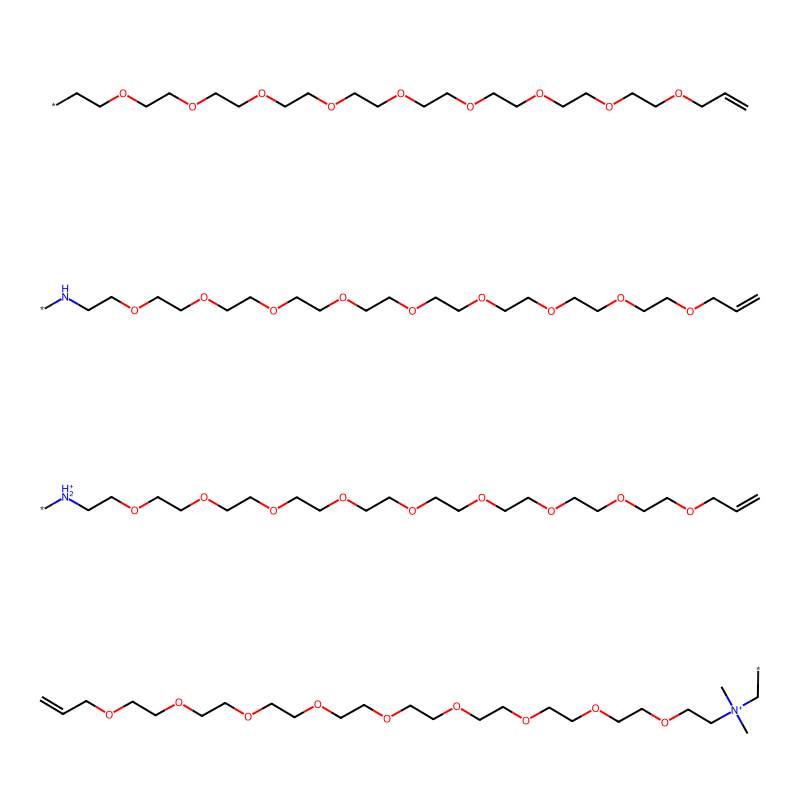

In [32]:
tail1_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "*"
tail2_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "N" + "*"
tail3_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "[NH2+]" + "*"
tail4_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "[N+](C)(C)C" + "*"

nEO = 9
tail1 = AllChem.MolFromSmiles(replaceDummy(tail1_smiles(nEO)))
tail2 = AllChem.MolFromSmiles(replaceDummy(tail2_smiles(nEO)))
tail3 = AllChem.MolFromSmiles(replaceDummy(tail3_smiles(nEO)))
tail4 = AllChem.MolFromSmiles(replaceDummy(tail4_smiles(nEO)))

img = AllChem.Draw.MolsToGridImage([tail1, tail2, tail3, tail4], molsPerRow=1, subImgSize=(800, 200))
img

# Some example bridges

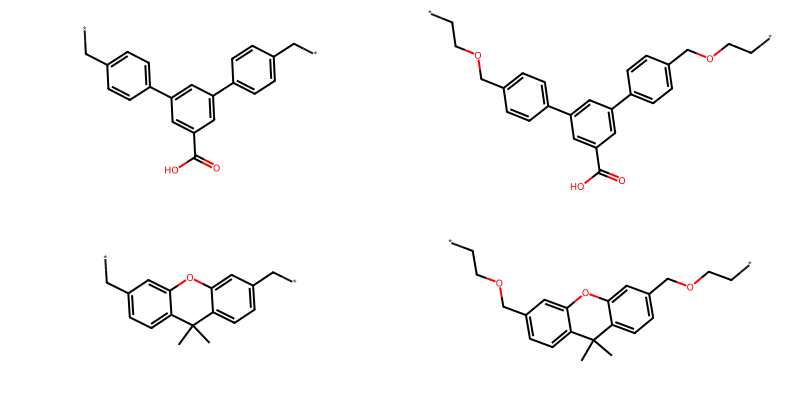

In [6]:
bridge1_smiles = lambda nEO: "O=C(O)c1cc(c2ccc(C" + "OCC" * nEO + "*)cc2)cc(c2ccc(C" + "OCC" * nEO + "*)cc2)c1"
bridge2_smiles = lambda nEO: "CC1(C)c2ccc(C" + "OCC" * nEO + "*)cc2Oc2cc(C" + "OCC" * nEO + "*)ccc21"

nEO_B = 0
bridge1_0 = AllChem.MolFromSmiles(replaceDummy(bridge1_smiles(nEO_B)))
bridge2_0 = AllChem.MolFromSmiles(replaceDummy(bridge2_smiles(nEO_B)))
nEO_B = 1
bridge1_1 = AllChem.MolFromSmiles(replaceDummy(bridge1_smiles(nEO_B)))
bridge2_1 = AllChem.MolFromSmiles(replaceDummy(bridge2_smiles(nEO_B)))
img = AllChem.Draw.MolsToGridImage([bridge1_0, bridge1_1, bridge2_0, bridge2_1], molsPerRow=2, subImgSize=(400, 200))
img

# Create ditopic binding motifs by "reaction" in RDKit
Here we demonstrate the formation of a ditopic binding motif

We first define reaction rule

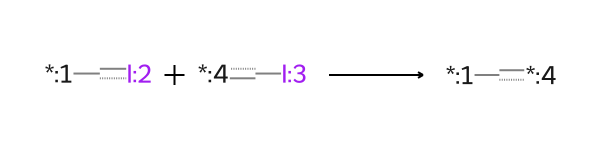

In [7]:
rxn = rdChemReactions.ReactionFromSmarts("[*:1][I:2].[I:3][*:4]>>[*:1][*:4]")
rxn

Create a reactant, where we change the dummy atom to I for reactions

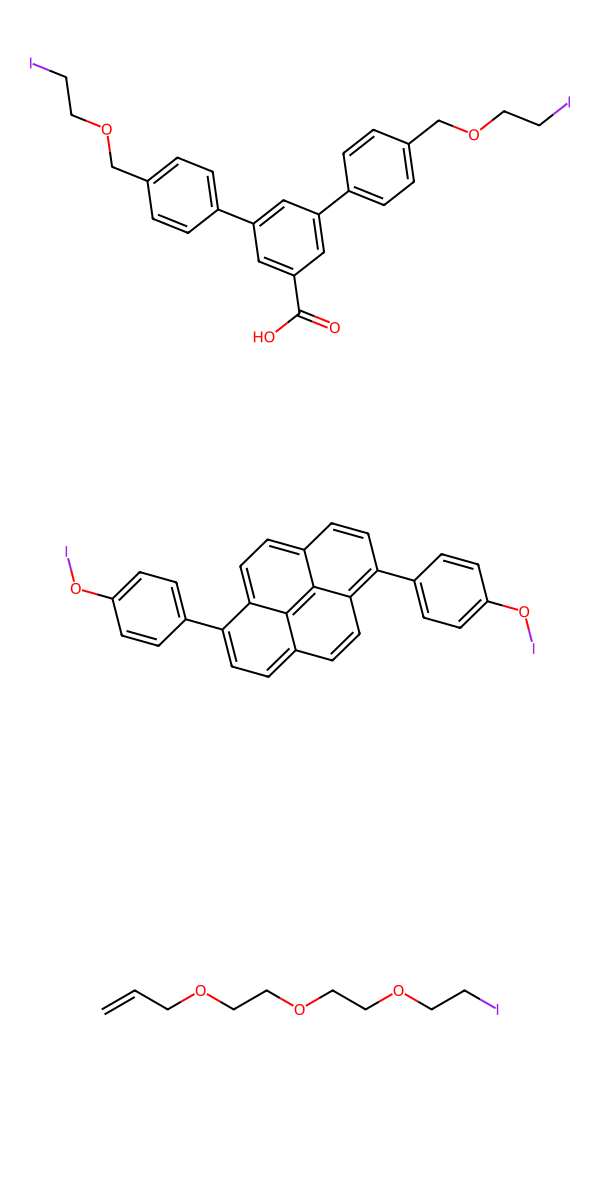

In [8]:
A = AllChem.MolFromSmiles(replaceDummy(bridge1_smiles(1), new="I"))
B = AllChem.MolFromSmiles(replaceDummy(core2_smiles, new="I"))
C = AllChem.MolFromSmiles(replaceDummy(tail1_smiles(3), new="I"))
img = AllChem.Draw.MolsToGridImage([A, B, C], molsPerRow=1, subImgSize=(600, 400))
img

Reaction takes three steps: \
(1) B(core) + C(tail) -> BC, since B has two I groups, there will be two possible but equivalent products. \
(2) BC + A -> BCA, since A has two I groups, there will be two possible but equivalent products. \
(3) BC + BCA -> BCACB, only one possible product

2


[13:33:55] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 3 


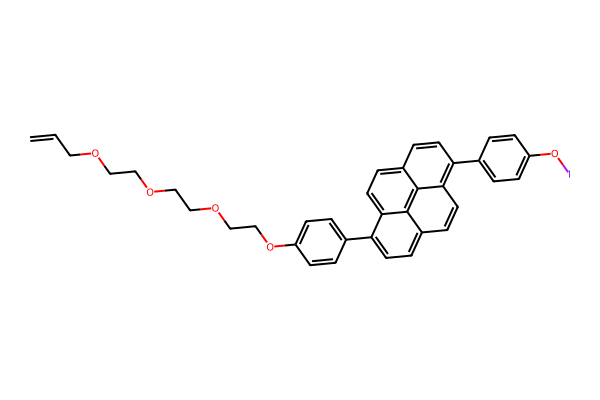

In [9]:
reacts = (B, C)
products = rxn.RunReactants(reacts)
print(len(products))    # output will be 2, since there will be two possible but equivalent products
BC = products[0][0]   # chose the first possible product (it does not make a different if we chose the second one by prod1 = products_1[1][0]
AllChem.SanitizeMol(BC)
img = AllChem.Draw.MolsToGridImage([BC], molsPerRow=1, subImgSize=(600, 400))
img

1


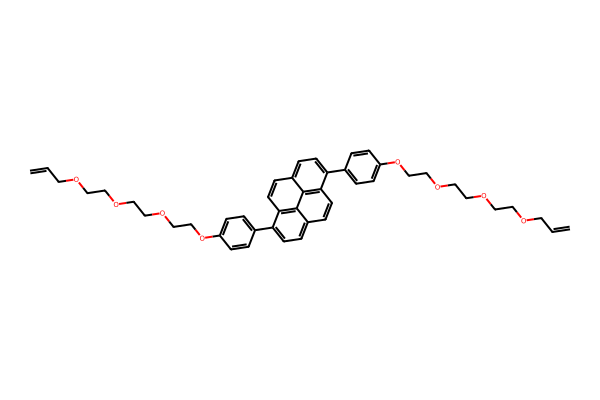

In [10]:
reacts = (BC, C)
products = rxn.RunReactants(reacts)
print(len(products))    # output will be 1, only one possible product
CBC = products[0][0]
AllChem.SanitizeMol(CBC)
img = AllChem.Draw.MolsToGridImage([CBC], molsPerRow=1, subImgSize=(600, 400))
img

2


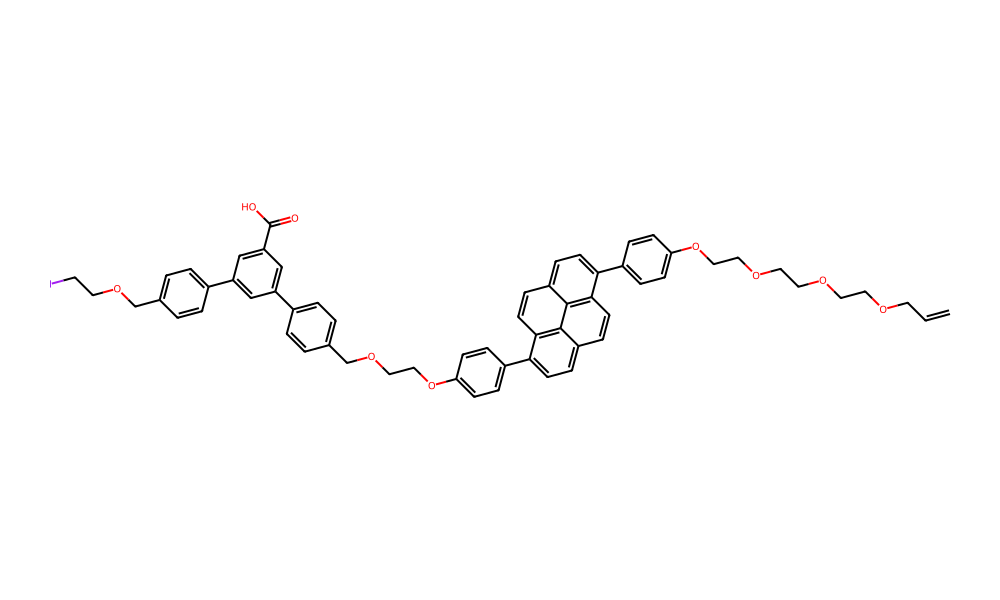

In [11]:
reacts = (BC, A)
products = rxn.RunReactants(reacts)
print(len(products))    # output will be 2, since there will be two possible but equivalent products
BCA = products[0][0]   # chose the first possible product (it does not make a different if we chose the second one by prod1 = products_1[1][0]
AllChem.SanitizeMol(BCA)
img = AllChem.Draw.MolsToGridImage([BCA], molsPerRow=1, subImgSize=(1000, 600))
img

1


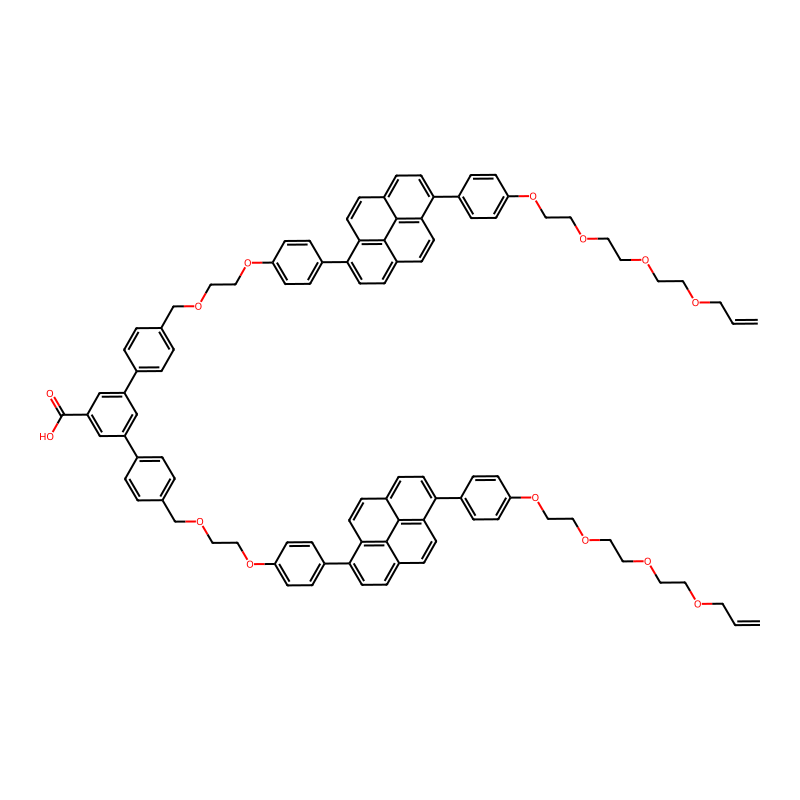

In [12]:
reacts = (BC, BCA)
products = rxn.RunReactants(reacts)
print(len(products))    # output will be 1, only one possible product
CBABC = products[0][0]
AllChem.SanitizeMol(CBABC)
img = AllChem.Draw.MolsToGridImage([CBABC], molsPerRow=1, subImgSize=(800, 800))
img

# Build residue files for molecular fragments

In [13]:
if os.path.exists("build_molecules"):
    shutil.rmtree("build_molecules")
os.mkdir("build_molecules")
shutil.copytree(files('silc.data.tutorial.build_molecules').joinpath('COR'), os.path.join("build_molecules", "COR"))
shutil.copytree(files('silc.data.tutorial.build_molecules').joinpath('BRD'), os.path.join("build_molecules", "BRD"))
shutil.copytree(files('silc.data.tutorial.build_molecules').joinpath('TLA_TLB'), os.path.join("build_molecules", "TLA_TLB"))

bm = binding_molecule()
bm.set_core_smiles(core2_smiles, "C")
bm.set_tail_smiles(tail1_smiles(3), "O")
bm.set_bridge_smiles(bridge1_smiles(1), "O")
bm.set_core_num_confs_for_charge(1)
bm.set_tail_num_confs_for_charge(5)
bm.set_bridge_num_confs_for_charge(5)
bm.set_work_path("build_molecules")

# Build a binding motif (i.e., tail-core-tail)

In [14]:
bm.create_binding_motif()

-I: Adding /home/heyi/env/py38/dat/leap/prep to search path.
-I: Adding /home/heyi/env/py38/dat/leap/lib to search path.
-I: Adding /home/heyi/env/py38/dat/leap/parm to search path.
-I: Adding /home/heyi/env/py38/dat/leap/cmd to search path.
-f: Source tleap_motif.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleap_motif.in
Log file: ./leap_motif.log
----- Source: /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2
----- Source of /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2 done
Log file: ./leap.log
Loading parameters: /home/heyi/env/py38/dat/leap/parm/gaff2.dat
Reading title:
AMBER General Force Field for organic molecules (Version 2.2.20, March 2021)
Loading Prep file: ./COR/molecule.prepi
Loading Prep file: ./TLA_TLB/molecule_head.prepi
Loading Prep file: ./TLA_TLB/molecule_tail.prepi
Writing pdb file: motif.pdb
Writing mol2 file: motif_Tripos.mol2
Writing mol2 file: motif.mol2
Checking Unit.
Building topology.
Building atom parameters.
Building bond parameters.
Building 

[13:33:56] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 3 


In [15]:
motif = util.read_amber_mol2(files('silc.data.tutorial.build_molecules').joinpath("motif.mol2"))
motif_block = AllChem.MolToMolBlock(motif)
viewer = py3Dmol.view(width=1000, height=500)
viewer.addModel(motif_block, 'mol')
viewer.setStyle({}, {'stick': {}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Build a ditopic molecule (i.e., tail-core-bridge-core-tail)

In [16]:
bm.create_ditopic_molecule()

-I: Adding /home/heyi/env/py38/dat/leap/prep to search path.
-I: Adding /home/heyi/env/py38/dat/leap/lib to search path.
-I: Adding /home/heyi/env/py38/dat/leap/parm to search path.
-I: Adding /home/heyi/env/py38/dat/leap/cmd to search path.
-f: Source tleap_ditopic.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleap_ditopic.in
Log file: ./leap_ditopic.log
----- Source: /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2
----- Source of /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2 done
Log file: ./leap.log
Loading parameters: /home/heyi/env/py38/dat/leap/parm/gaff2.dat
Reading title:
AMBER General Force Field for organic molecules (Version 2.2.20, March 2021)
Loading Prep file: ./COR/molecule.prepi
Loading Prep file: ./TLA_TLB/molecule_head.prepi
Loading Prep file: ./TLA_TLB/molecule_tail.prepi
Loading Prep file: ./BRD/molecule.prepi
Writing pdb file: ditopic.pdb
Writing mol2 file: ditopic_Tripos.mol2
Writing mol2 file: ditopic.mol2
Checking Unit.
Building topology.
Building 

[13:33:56] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 3 


In [17]:
ditopic = util.read_amber_mol2(files('silc.data.tutorial.build_molecules').joinpath("ditopic.mol2"))
ditopic_block = AllChem.MolToMolBlock(ditopic)
viewer = py3Dmol.view(width=1000, height=500)
viewer.addModel(ditopic_block, 'mol')
viewer.setStyle({}, {'stick': {}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Align the molecules with those in complex

In [18]:
receptor = AllChem.MolFromPDBFile(str(files('silc.data.receptor').joinpath('GCDOH.pdbqt')), removeHs=False)

### run docking with AutoDock4 potential
d_ad4 = dock(sf_name='ad4', receptor_name='GCDOH')
#d_ad4.prepare_ligand_from_smiles(motifB_smiles(0))
#d_ad4.run(n_ligand=1)
#d_ad4.run(n_ligand=2)
d_ad4.load_results(files('silc.data.tutorial.docking').joinpath('GCDOH_2_ligand_ad4.pdbqt'), n_ligand=2)
d_ad4.visualize(n_ligand=2, pose_id=19)

Found receptor GCDOH in database at /home/heyi/Projects/Interlock/silc/silc/data/receptor/GCDOH.pdb
Reading AD4.2 maps ... done.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Align binding motif

In [19]:
ligand0, ligand1 = d_ad4.ligand_mol(n_ligand=2, pose_id=19)
core = AllChem.MolFromSmiles(replaceDummy(core2_smiles,""))
expanded_core0 = util.expand_substructure(ligand0, core, expand_iteration=1)
expanded_core1 = util.expand_substructure(ligand1, core, expand_iteration=1)
motif0 = util.align_to_substructure(CBC, expanded_core0, stretch=True)
motif1 = util.align_to_substructure(CBC, expanded_core1, stretch=True)
receptor, [motif0, motif1] = util.optimize_complex(receptor, [motif0, motif1], [expanded_core0, expanded_core1])
motif0h = util.add_Hs(motif0)
motif1h = util.add_Hs(motif1)

[13:33:56] combineMols: conformer id 0 not found in mol2[13:33:56] combineMols: conformer id 0 not found in mol2[13:33:56] Molecule does not have explicit Hs. Consider calling AddHs()
[13:33:56] Molecule does not have explicit Hs. Consider calling AddHs()
[13:33:56] Molecule does not have explicit Hs. Consider calling AddHs()
[13:33:57] Molecule does not have explicit Hs. Consider calling AddHs()
[13:33:57] Molecule does not have explicit Hs. Consider calling AddHs()
[13:33:57] Molecule does not have explicit Hs. Consider calling AddHs()
[13:33:57] Molecule does not have explicit Hs. Consider calling AddHs()


In [20]:
receptor_block = AllChem.MolToMolBlock(receptor)
motif0_block = AllChem.MolToMolBlock(motif0h)
motif1_block = AllChem.MolToMolBlock(motif1h)

viewer = py3Dmol.view(width=500, height=500)
viewer.addModel(motif0_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {}})
viewer.addModel(motif1_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {}})
viewer.addModel(receptor_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {'color':'green'}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [21]:
mol0 = AllChem.MolFromPDBFile(str(files('silc.data.tutorial.build_molecules').joinpath("motif.pdb")), removeHs=False)
mol0 = AllChem.AssignBondOrdersFromTemplate(motif0h, mol0)
mol0 = util.align_to_substructure(mol0, motif0h)
mol1 = AllChem.MolFromPDBFile(str(files('silc.data.tutorial.build_molecules').joinpath("motif.pdb")), removeHs=False)
mol1 = AllChem.AssignBondOrdersFromTemplate(motif1h, mol1)
mol1 = util.align_to_substructure(mol1, motif1h)

[13:34:05] WARNING: More than one matching pattern found - picking one

[13:34:06] WARNING: More than one matching pattern found - picking one



In [22]:
receptor_block = AllChem.MolToMolBlock(receptor)
mol0_block = AllChem.MolToMolBlock(mol0)
mol1_block = AllChem.MolToMolBlock(mol1)

viewer = py3Dmol.view(width=500, height=500)
viewer.addModel(mol0_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {}})
viewer.addModel(mol1_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {}})
viewer.addModel(receptor_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {'color':'green'}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Align ditopic molecule

In [23]:
ligand0, ligand1 = d_ad4.ligand_mol(n_ligand=2, pose_id=19)
core = AllChem.MolFromSmiles(replaceDummy(core2_smiles,""))
expanded_core0 = util.expand_substructure(ligand0, core, expand_iteration=1)
mol = AllChem.MolFromPDBFile(str(files('silc.data.tutorial.build_molecules').joinpath("ditopic.pdb")), removeHs=False)
m = AllChem.Mol(mol)
m = AllChem.AssignBondOrdersFromTemplate(CBABC, m)
match = m.GetSubstructMatches(expanded_core0)
pair1 = [(match[0][i], i) for i in range(len(match[0]))]
pair2 = [(match[1][i], i) for i in range(len(match[1]))]
AllChem.AlignMol(m, expanded_core0, atomMap=pair1)
comb = AllChem.CombineMols(m, receptor)
AllChem.AlignMol(comb, expanded_core0, atomMap=pair2)
comb = AllChem.CombineMols(comb, receptor)

frags = AllChem.GetMolFrags(comb, asMols=True)
ditopic = frags[0]
receptor0 = frags[1]
receptor1 = frags[2]


[13:34:06] WARNING: More than one matching pattern found - picking one



In [24]:
ditopic_block = AllChem.MolToMolBlock(ditopic)
receptor0_block = AllChem.MolToMolBlock(receptor0)
receptor1_block = AllChem.MolToMolBlock(receptor1)

viewer = py3Dmol.view(width=500, height=500)
viewer.addModel(ditopic_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {}})
viewer.addModel(receptor0_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {'color':'green'}})
viewer.addModel(receptor1_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {'color':'green'}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [25]:
c = complex()
c.set_work_path("complex")
c.set_binding_molecule(bm)
c.set_dock(d_ad4)

In [26]:
c.create_receptor_motif_complex(n_motif=2, dock_pose_id=19)

[13:34:06] WARNING: More than one matching pattern found - picking one

[13:34:09] WARNING: More than one matching pattern found - picking one

[13:34:12] Molecule does not have explicit Hs. Consider calling AddHs()



Welcome to antechamber 22.0: molecular input file processor.

Info: acdoctor mode is on: check and diagnose problems in the input file.
Info: The atom type is set to gaff2; the options available to the -at flag are
      gaff, gaff2, amber, bcc, and sybyl.

-- Check Format for pdb File --
   Status: pass
-- Check Unusual Elements --
   Status: pass
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.


---Judge bond type for Residue 1 with ID of 1 and Name of TLA ---

---Judge bond type for Residue 2 with ID of 2 and Name of COR ---

---Judge bond type for Residue 3 with ID of 3 and Name of TLB ---


Welcome to antechamber 22.0: molecular input file processor.

Info: acdoctor mode is on: check and diagnose problems in the input file.
Info: The atom type is set to gaff2;

In [27]:
comb = AllChem.MolFromMol2File(os.path.join(c.work_path, "motif_complex_Tripos.mol2"), removeHs=False)
comb_block = AllChem.MolToMolBlock(comb)

viewer = py3Dmol.view(width=500, height=500)
viewer.addModel(comb_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [28]:
c.create_receptor_ditopic_complex()

[13:34:51] WARNING: More than one matching pattern found - picking one




Welcome to antechamber 22.0: molecular input file processor.

Info: acdoctor mode is on: check and diagnose problems in the input file.
Info: The atom type is set to gaff2; the options available to the -at flag are
      gaff, gaff2, amber, bcc, and sybyl.

-- Check Format for pdb File --
   Status: pass
-- Check Unusual Elements --
   Status: pass
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.


---Judge bond type for Residue 1 with ID of 1 and Name of TLA ---

---Judge bond type for Residue 2 with ID of 2 and Name of COR ---

---Judge bond type for Residue 3 with ID of 3 and Name of BRD ---

---Judge bond type for Residue 4 with ID of 4 and Name of COR ---

---Judge bond type for Residue 5 with ID of 5 and Name of TLB ---

-I: Adding /home/heyi/env/py38/dat/leap

In [29]:
comb = AllChem.MolFromMol2File(os.path.join(c.work_path, "ditopic_complex_Tripos.mol2"), removeHs=False)
comb_block = AllChem.MolToMolBlock(comb)

viewer = py3Dmol.view(width=500, height=500)
viewer.addModel(comb_block, 'mol')
viewer.setStyle({'model':-1,}, {'stick': {}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol